Computational Constraints:
Because the ASL and WLASL datasets are extremely large and Google Colab limits GPU time, the training sets were intentionally reduced using stratified sampling.
This allowed every experiment to run within Colab’s runtime limits while still enabling full ablation analysis.

Reproducibility Instructions: To allow anyone to run this notebook without errors, please follow the instructions below.

1. Mount Google Drive
- This notebook assumes datasets are stored in Google Drive.
  - ***from google.colab import drive***
  - ***drive.mount('/content/drive')***
- After mounting, all file paths must begin with:
  - ***/content/drive/MyDrive***

2. Update Dataset Paths
- In the *configuration.py* block, these must point to your actual files:
  -  ***ASL_TRAIN_SET = "/content/drive/MyDrive/DAEN429Project/asl_alphabet_train"***
  -  ***ASL_TEST_SET = "/content/drive/MyDrive/DAEN429Project/asl_alphabet_test"***
  -  ***WLASL100_SET = "/content/drive/MyDrive/DAEN429Project/WLASL_100"***
  -  ***CHECKPOINT_DIR = "/content/drive/MyDrive/DAEN429Project/checkpoints"***
  -  ***FIGURE_DIR = "/content/drive/MyDrive/DAEN429Project/figures"***

* Change "MyDrive/DAEN429Project" to match your folder name.

Adjustable Training Size:
- For computational reasons, this notebook includes a ***reduction_ratio*** setting.

- To train on the full dataset, set: ***reduction_ratio = 1.0***

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/DAEN429Project


asl_alphabet_test   checkpoints      figures	      WLASL_100
asl_alphabet_train  DAEN429_Project  Untitled0.ipynb


In [14]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms, models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Set seed
def global_seed(seed = 429):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

global_seed()

class configuration:
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

  ASL_TRAIN_SET = "/content/drive/MyDrive/DAEN429Project/asl_alphabet_train"
  ASL_TEST_SET = "/content/drive/MyDrive/DAEN429Project/asl_alphabet_test"

  WLASL100_SET = "/content/drive/MyDrive/DAEN429Project/WLASL_100"

  FRAME_NUM = 16

  # Model Settings
  ASL_CLASSES_NUM = 29
  BATCH_SIZE = 128
  NUM_WORKERS = 0
  LR = 1e-3
  WEIGHT_DECAY = 1e-4
  TA_EPOCHS = 2
  TB_EPOCHS = 2
  TC_EPOCHS = 2
  SA_EPOCHS = 3
  P2_EPOCHS = 5
  P2_LR = 1e-4

  CHECKPOINT_DIR = "/content/drive/MyDrive/DAEN429Project/checkpoints"
  FIGURE_DIR = "/content/drive/MyDrive/DAEN429Project/figures"

# Create directories for saving results
os.makedirs(configuration.CHECKPOINT_DIR, exist_ok=True)
os.makedirs(configuration.FIGURE_DIR, exist_ok=True)

print(f"Setup complete. Using device: {configuration.DEVICE}")



Setup complete. Using device: cuda


In [16]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Building train/val split (seed = 429)
from sklearn.model_selection import train_test_split

def build_asl_train_val(seed=429, reduction_ratio=0.005):

    print(f"\n=== Building ASL Train/Val Split (Using {int(reduction_ratio*100)}% of dataset) ===")

    # Load full dataset once
    full_train = datasets.ImageFolder(configuration.ASL_TRAIN_SET, transform=train_transform)
    class_names = full_train.classes

    indices = np.arange(len(full_train))
    labels = np.array(full_train.targets)

    # Reduction
    reduced_idx, _ = train_test_split(
        indices,
        train_size=reduction_ratio,
        stratify=labels,
        random_state=seed
    )

    print(f"Original dataset size: {len(full_train)}")
    print(f"Reduced dataset size:  {len(reduced_idx)}")

    # Build reduced dataset for training transforms
    reduced_dataset_train = Subset(full_train, reduced_idx)

    full_train_eval = datasets.ImageFolder(configuration.ASL_TRAIN_SET, transform=eval_transform)
    reduced_dataset_eval = Subset(full_train_eval, reduced_idx)

    # Extract labels of reduced subset for second split
    reduced_labels = labels[reduced_idx]

    # Train/Val Split (80/20)
    train_idx, val_idx = train_test_split(
        np.arange(len(reduced_idx)),
        test_size=0.2,
        stratify=reduced_labels,
        random_state=seed
    )

    train_dataset = Subset(reduced_dataset_train, train_idx)
    val_dataset = Subset(reduced_dataset_eval, val_idx)

    print(f"Final Train size: {len(train_dataset)}")
    print(f"Final Val size:   {len(val_dataset)}")
    print(f"Classes: {class_names}")

    return train_dataset, val_dataset, class_names


class ASLCustomTestSet(Dataset):
  def __init__(self, root, transform, class_to_idx):
      self.root = root
      self.transform = transform
      self.samples = []
      self.class_to_idx = class_to_idx

      for fname in os.listdir(root):
          if fname.lower().endswith((".jpg", ".jpeg", ".png")):
              match = re.match(r"([A-Za-z]+)", fname)
              if not match:
                  raise ValueError(f"Could not parse label from filename: {fname}")

              raw_label = match.group(1)


              candidates = [
                  raw_label,
                  raw_label.lower(),
                  raw_label.upper()
              ]

              label = None
              for c in candidates:
                  if c in class_to_idx:
                      label = class_to_idx[c]
                      break

              if label is None:
                  raise ValueError(f"Unknown label '{raw_label}' in file {fname}")

              path = os.path.join(root, fname)
              self.samples.append((path, label))

      print(f"Loaded {len(self.samples)} custom test images from {root}")

  def __len__(self):
      return len(self.samples)

  def __getitem__(self, idx):
      path, label = self.samples[idx]
      img = Image.open(path).convert("RGB")
      img = self.transform(img)
      return img, label



# Flat Test Folder Dataset
class ASLTestSet(Dataset):
  def __init__(self, root, transform, class_to_idx):
    self.root = root
    self.transform = transform
    self.samples = []
    self.class_to_idx = class_to_idx

    for fname in os.listdir(root):
      if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        label_name = fname.split("_")[0]
        label_name = label_name.strip()

        key1 = label_name.lower()
        key2 = label_name.upper()

        if key1 in class_to_idx:
          label = class_to_idx[key1]
        elif key2 in class_to_idx:
          label = class_to_idx[key2]
        else:
          raise ValueError("Unknown test label.")

        path = os.path.join(root, fname)
        self.samples.append((path, label))

    print(f"Loaded {len(self.samples)} test images from {root}")

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    path, label = self.samples[idx]
    img = Image.open(path).convert("RGB")
    img = self.transform(img)
    return img, label

# Building Model Resnet-18
def build_resnet18_model(num_classes = configuration.ASL_CLASSES_NUM, pretrained = True):
  model = models.resnet18(pretrained = pretrained)
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, num_classes)
  return model

  # Freezing/Unfreezing Policies, Ablations
def freeze_policy(model):
  for name, p in model.named_parameters():
    if not name.startswith("fc."):
      p.requires_grad = False


def freeze_except_layer4(model):
  for p in model.parameters():
    p.requires_grad = False

  for name, p in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc."):
      p.requires_grad = True

def unfreeze_layer3_and_4(model):
  for p in model.parameters():
    p.requires_grad = False

  for name, p in model.named_parameters():
    if name.startswith("layer3") or name.startswith("layer4") or name.startswith("fc."):
      p.requires_grad = True

# Training Utilities
def compute_metrics(y_true, y_pred):
  return {
      "accuracy": accuracy_score(y_true, y_pred),
      "f1": f1_score(y_true, y_pred, average = "macro")
  }

def run_epoch(model, loader, criterion, optimizer = None):
  train_mode = optimizer is not None

  model.train(train_mode)
  total_loss = 0
  y_true = []
  y_pred = []

  for x, y in loader:
    x = x.to(configuration.DEVICE)
    y = y.to(configuration.DEVICE)

    if train_mode:
      optimizer.zero_grad()

    logits = model(x)
    loss = criterion(logits, y)

    if train_mode:
      loss.backward()
      optimizer.step()

    total_loss += loss.item() * x.size(0)

    preds = logits.argmax(dim = 1)
    y_true.extend(y.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

  avg_loss = total_loss / len(loader.dataset)
  metrics = compute_metrics(y_true, y_pred)

  return avg_loss, metrics, y_true, y_pred


# Training Loop / Model
def train_model(model, train_loader, val_loader, num_epochs, exp_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr = configuration.LR,
        weight_decay = configuration.WEIGHT_DECAY
    )

    optimal_f1 = -1
    best_state = None

    hist = {
        "train_loss": [],
        "val_loss": [],
        "train_f1": [],
        "val_f1": []
    }

    for epoch in range(num_epochs):
        train_loss, train_metrics, _, _ = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_metrics, _, _ = run_epoch(model, val_loader, criterion)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["train_f1"].append(train_metrics["f1"])
        hist["val_f1"].append(val_metrics["f1"])

        print(f"[{exp_name}] Epoch {epoch+1}/{num_epochs} | "
              f"Train F1={train_metrics['f1']:.4f} | Val F1={val_metrics['f1']:.4f}")

        if val_metrics["f1"] > optimal_f1:
            optimal_f1 = val_metrics["f1"]
            best_state = model.state_dict()

        checkpt_path = f"{configuration.CHECKPOINT_DIR}/{exp_name}_best.pt"
        torch.save(best_state, checkpt_path)
        print("Model Saved.")

    # load best checkpoint AFTER all epochs
    model.load_state_dict(best_state)
    return model, hist








=== Building ASL Train/Val Split (Using 0% of dataset) ===
Original dataset size: 87000
Reduced dataset size:  435
Final Train size: 348
Final Val size:   87
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

===== Running T-A (Head Only) =====


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[T_A] Epoch 1/2 | Train F1=0.0316 | Val F1=0.0268
Model Saved.
[T_A] Epoch 2/2 | Train F1=0.0582 | Val F1=0.0526
Model Saved.

===== Running T-B (Unfreeze Layer4 + Head) =====


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[T_B] Epoch 1/2 | Train F1=0.1671 | Val F1=0.3728
Model Saved.
[T_B] Epoch 2/2 | Train F1=0.8493 | Val F1=0.6169
Model Saved.

===== Running T-C (Layer3 + Layer4 + Head) =====


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[T_C] Epoch 1/2 | Train F1=0.8391 | Val F1=0.6236
Model Saved.
[T_C] Epoch 2/2 | Train F1=0.9306 | Val F1=0.6646
Model Saved.

===== Running S-A (ResNet from Scratch) =====


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[S_A] Epoch 1/3 | Train F1=0.0303 | Val F1=0.0066
Model Saved.
[S_A] Epoch 2/3 | Train F1=0.0530 | Val F1=0.0016
Model Saved.
[S_A] Epoch 3/3 | Train F1=0.1251 | Val F1=0.0059
Model Saved.

 Validation Results (Macro F1)
T-A: 0.0526
T-B: 0.6169
T-C: 0.6646
S-A: 0.0059

 Best Model = T-C
Best Model Checkpoint: /content/drive/MyDrive/DAEN429Project/checkpoints/T_C_best.pt


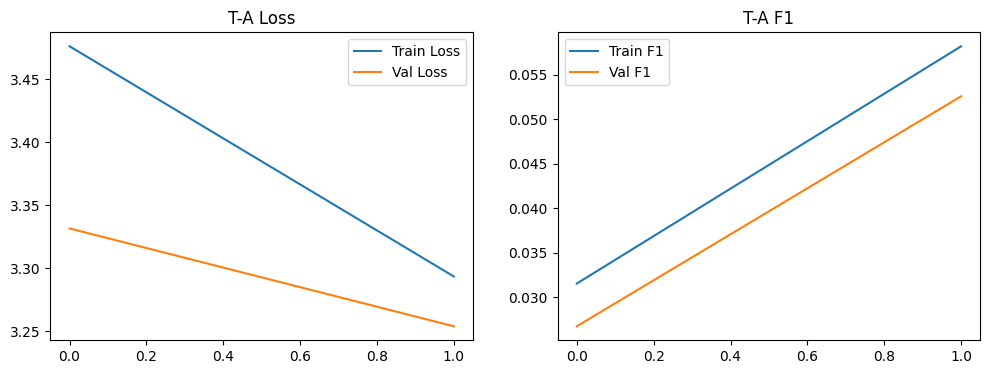

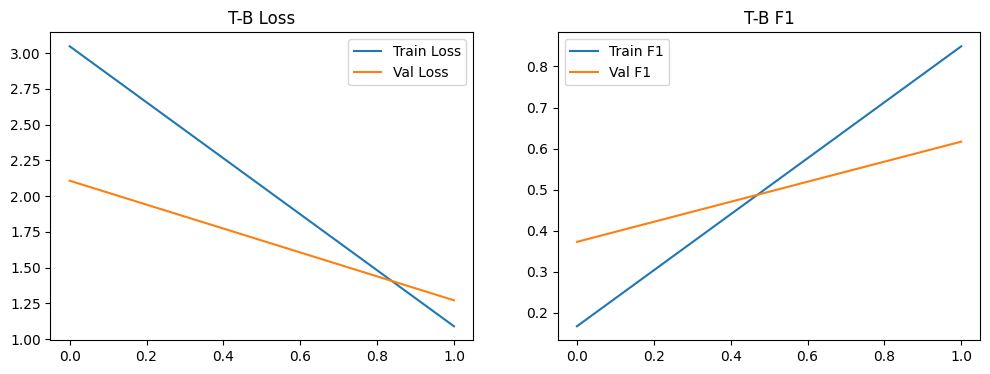

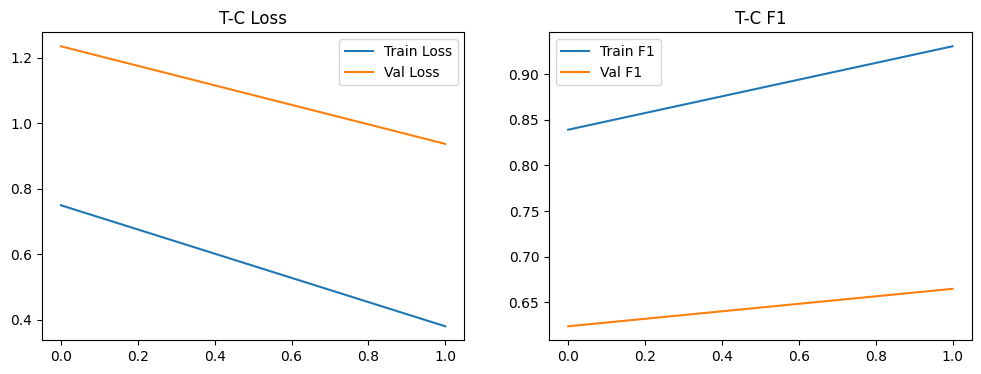

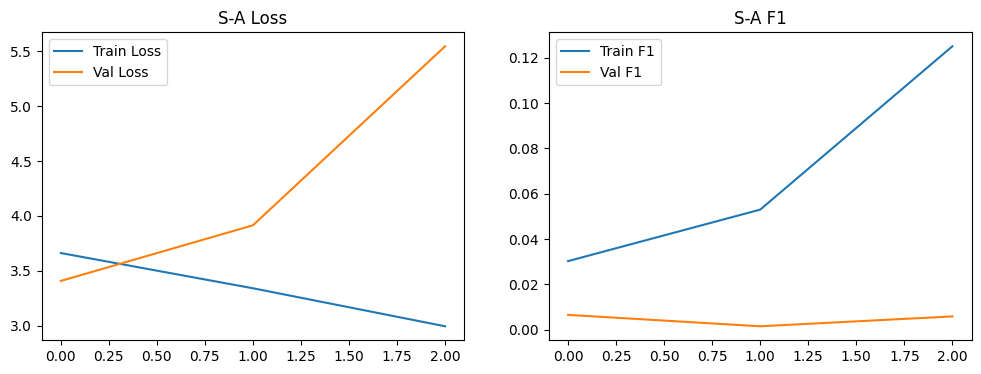

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Best model for test evaluation:  T-C
Loaded 28 test images from /content/drive/MyDrive/DAEN429Project/asl_alphabet_test

 Test Set Results:
Accuracy: 0.8929
F1 Score: 0.8631

Custom Test Set Evaluation:
Loaded 20 custom test images from /content/drive/MyDrive/DAEN429Project/asl_custom_test

Custom Test Set Results:
Accuracy: 1.0000
F1 Score: 1.0000


In [17]:
# Running Ablations, and Eval

def plot_history(hist, title):
  fig, ax = plt.subplots(1, 2, figsize = (12, 4))
  ax[0].plot(hist["train_loss"], label = "Train Loss")
  ax[0].plot(hist["val_loss"], label = "Val Loss")
  ax[0].set_title(f"{title} Loss")
  ax[0].legend()

  ax[1].plot(hist["train_f1"], label = "Train F1")
  ax[1].plot(hist["val_f1"], label = "Val F1")
  ax[1].set_title(f"{title} F1")
  ax[1].legend()
  plt.show()


train_dataset, val_dataset, class_names = build_asl_train_val()
train_loader = DataLoader(train_dataset, batch_size = configuration.BATCH_SIZE, shuffle = True, num_workers = configuration.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size = configuration.BATCH_SIZE, shuffle = False, num_workers = configuration.NUM_WORKERS)

results = {}
histories = {}

# Running T-A: Head Only Fine Tuning
print("\n===== Running T-A (Head Only) =====")
model_ta = build_resnet18_model(pretrained = True).to(configuration.DEVICE)
freeze_policy(model_ta)

model_ta, hist_ta = train_model(model_ta, train_loader, val_loader, configuration.TA_EPOCHS, exp_name = "T_A")
results["T-A"] = hist_ta["val_f1"][-1]
histories["T-A"] = hist_ta

# Running T-B: Unfreeze Layer4 + Head
print("\n===== Running T-B (Unfreeze Layer4 + Head) =====")
model_tb = build_resnet18_model(pretrained = True).to(configuration.DEVICE)
freeze_except_layer4(model_tb)

model_tb, hist_tb = train_model(model_tb, train_loader, val_loader, configuration.TB_EPOCHS, exp_name = "T_B")
results["T-B"] = hist_tb["val_f1"][-1]
histories["T-B"] = hist_tb

# Running T-C: Layer3 + Layer4 + Head)
print("\n===== Running T-C (Layer3 + Layer4 + Head) =====")
model_tc = build_resnet18_model(pretrained = True).to(configuration.DEVICE)
tb_path = f"{configuration.CHECKPOINT_DIR}/T_B_best.pt"
model_tc.load_state_dict(torch.load(tb_path, map_location = configuration.DEVICE))
unfreeze_layer3_and_4(model_tc)

model_tc, hist_tc = train_model(model_tc, train_loader, val_loader, configuration.TC_EPOCHS, exp_name = "T_C")
results["T-C"] = hist_tc["val_f1"][-1]
histories["T-C"] = hist_tc

# Running S-A: ResNet from Scratch
print("\n===== Running S-A (ResNet from Scratch) =====")
model_sa = build_resnet18_model(pretrained = False).to(configuration.DEVICE)
model_sa, hist_sa = train_model(model_sa, train_loader, val_loader, configuration.SA_EPOCHS, exp_name = "S_A")
results["S-A"] = hist_sa["val_f1"][-1]
histories["S-A"] = hist_sa

# Select Best Model
print("\n Validation Results (Macro F1)")
for k, v in results.items():
  print(f"{k}: {v:.4f}")

best_model_name = max(results, key = results.get)
print (f"\n Best Model = {best_model_name}")

best_ckpt_name = {
    "T-A": "T_A_best.pt",
    "T-B": "T_B_best.pt",
    "T-C": "T_C_best.pt",
    "S-A": "S_A_best.pt"
}[best_model_name]

best_ckpt_path = f"{configuration.CHECKPOINT_DIR}/{best_ckpt_name}"
print(f"Best Model Checkpoint: {best_ckpt_path}")


for k, hist in histories.items():
  plot_history(hist, title = k)


# Loading best model for eval
best_model = build_resnet18_model(pretrained = True).to(configuration.DEVICE)
best_model.load_state_dict(torch.load(best_ckpt_path, map_location = configuration.DEVICE))
best_model.eval()

print("\n Best model for test evaluation: ", best_model_name)


# Flat Test Set eval
class_to_idx = {c.lower(): i for i, c in enumerate(class_names)}
class_to_idx.update({c: i for i, c in enumerate(class_names)})
test_dataset = ASLTestSet(configuration.ASL_TEST_SET, eval_transform, class_to_idx)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

criterion = nn.CrossEntropyLoss()

test_loss, test_metrics, y_true, y_pred = run_epoch(best_model, test_loader, criterion, optimizer = None)

print("\n Test Set Results:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")

print("\nCustom Test Set Evaluation:")

CUSTOM_TEST_ROOT = "/content/drive/MyDrive/DAEN429Project/asl_custom_test"

custom_test_dataset = ASLCustomTestSet(CUSTOM_TEST_ROOT, eval_transform, class_to_idx)

custom_test_loader = DataLoader(custom_test_dataset, batch_size=32, shuffle=False)

custom_loss, custom_metrics, y_true_c, y_pred_c = run_epoch(best_model, custom_test_loader, nn.CrossEntropyLoss(), optimizer=None)

print("\nCustom Test Set Results:")
print(f"Accuracy: {custom_metrics['accuracy']:.4f}")
print(f"F1 Score: {custom_metrics['f1']:.4f}")




# Building Confusion Matrix
def plot_conf_matrix(y_true, y_pred, labels):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize = (12, 12))
  im = ax.imshow(cm, cmap = "Blues")

  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))
  ax.set_xticklabels(labels, rotation = 90)
  ax.set_yticklabels(labels)

  plt.title("Confusion Matrix")
  plt.colorbar(im)
  plt.show()

  plot_conf_matrix(y_true, y_pred, class_names)





In [ ]:
# Phase 2: Dynamic WLASL100 Word Recognition LSTM



def load_video_frames(path, num_frames = configuration.FRAME_NUM):
  cap = cv2.VideoCapture(path)
  frames = []
  while True:
    ret, frame = cap.read()
    if not ret:
      break
    frames.append(frame[:, :, ::-1])
  cap.release()

  if len(frames) == 0:
    frames = [np.zeros((224, 224, 3), dtype = np.uint8)]* num_frames

  idxs = np.linspace(0, len(frames) - 1, num_frames).astype(int)
  sampled = [frames[i] for i in idxs]

  sampled = [Image.fromarray(f) for f in sampled]
  return sampled


# WLASL Dataset Class
class WLASL_Dataset(Dataset):
    def __init__(self, root, split, transform=eval_transform, num_frames=16, reduction_ratio = 1.0):
        self.transform = transform
        self.num_frames = num_frames

        split_dir = os.path.join(root, split)
        self.samples = []

        self.class_names = sorted(os.listdir(split_dir))
        self.class_to_idx = {c: i for i, c in enumerate(self.class_names)}

        for cls in self.class_names:
            cls_dir = os.path.join(split_dir, cls)
            videos = [f for f in os.listdir(cls_dir) if f.endswith(".mp4")]

            # Reduce videos per class
            keep = int(len(videos) * reduction_ratio)
            videos = videos[:max(1, keep)]

            for fname in videos:
                path = os.path.join(cls_dir, fname)
                self.samples.append((path, self.class_to_idx[cls]))

        print(f"Loaded {len(self.samples)} {split} videos (Reduction ratio = {reduction_ratio})")


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        frames = load_video_frames(path, num_frames = self.num_frames)
        frames = [self.transform(f) for f in frames]

        return torch.stack(frames, dim = 0), label

# Import Best Phase 1 Model
def load_best_model(best_ckpt_path):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Identity()

    # Load checkpoint FIRST
    checkpoint = torch.load(best_ckpt_path, map_location=configuration.DEVICE)

    # Then load state dict with strict=False
    model.load_state_dict(checkpoint, strict=False)

    model.to(configuration.DEVICE)
    model.eval()
    return model


# Temp Model LSTM
class TempLSTM(nn.Module):
  def __init__(self, feature_dim = 512, hidden_dim = 256, num_classes = 100):
    super().__init__()
    self.lstm = nn.LSTM(
        input_size = feature_dim,
        hidden_size = hidden_dim,
        batch_first = True
    )
    self.fc = nn.Linear(hidden_dim, num_classes)

  def forward(self, x):
    out, _ = self.lstm(x)
    last_hidden = out[:, -1, :]
    logits = self.fc(last_hidden)
    return logits

# Feature Extraction Function
def extract_features(model, frames):
  B, T, C, H, W = frames.shape
  frames = frames.view(B*T, C, H, W)
  with torch.no_grad():
    feats = model(frames.to(configuration.DEVICE))
  return feats.view(B, T, -1)


# Training Loop for Phase 2
def train_phase2(feature_model, train_loader, val_loader, trainable_layer4 = False):
  if trainable_layer4:
    print(" Unfreezing layer4 of resnet")
    for name, p in feature_model.named_parameters():
      if name.startswith("layer4"):
        p.required_grad = True
      else:
        p.required_grad = False
  else:
    print("Freezing")
    for p in feature_model.parameters():
      p.requires_grad = False

  lstm_head = TempLSTM(num_classes = len(train_loader.dataset.class_names)).to(configuration.DEVICE)
  params = list(filter(lambda p: p.requires_grad, feature_model.parameters())) + list(lstm_head.parameters())

  optimizer = torch.optim.Adam(params, lr = configuration.P2_LR)
  criterion = nn.CrossEntropyLoss()

  optimal_f1 = -1
  best_state = None

  for epoch in range(configuration.P2_EPOCHS):
    feature_model.train()
    lstm_head.train()
    y_true = []
    y_pred = []
    total_loss = 0

    for frames, labels in train_loader:
      frames = frames.to(configuration.DEVICE)
      labels = labels.to(configuration.DEVICE)

      optimizer.zero_grad()
      feats = extract_features(feature_model, frames)
      logits = lstm_head(feats)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * frames.size(0)

      preds = logits.argmax(dim = 1).detach().cpu().numpy()
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(preds)

    train_f1 = f1_score(y_true, y_pred, average = "macro")
    train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{configuration.P2_EPOCHS} | Loss={train_loss:.4f} | F1={train_f1:.4f}")


    feature_model.eval()
    lstm_head.eval()
    val_true = []
    val_pred = []

    with torch.no_grad():
      for frames, labels in val_loader:
        feats = extract_features(feature_model, frames.to(configuration.DEVICE))
        logits = lstm_head(feats)
        preds = logits.argmax(dim = 1).cpu().numpy()
        val_pred.extend(preds)
        val_true.extend(labels.numpy())

    val_f1 = f1_score(val_true, val_pred, average = "macro")
    print(f"Val F1={val_f1:.4f}")

    if val_f1 > optimal_f1:
      optimal_f1 = val_f1
      best_state = {
          "cnn": feature_model.state_dict(),
          "head": lstm_head.state_dict()
      }

  return best_state, optimal_f1


# Load WLASL Data
train_wlasl = WLASL_Dataset(configuration.WLASL100_SET, "train", reduction_ratio = 0.005)
val_wlasl = WLASL_Dataset(configuration.WLASL100_SET, "val", reduction_ratio = 0.005)
test_wlasl = WLASL_Dataset(configuration.WLASL100_SET, "test", reduction_ratio = 0.05)

train_loader_w = DataLoader(train_wlasl, batch_size = 4, shuffle = True)
val_loader_w = DataLoader(val_wlasl, batch_size = 4, shuffle = False)
test_loader_w = DataLoader(test_wlasl, batch_size = 4, shuffle = False)

# Load Best Phase 1 Model
print("\n Loading Phase 1 Best Model for Feature Extraction")
feature_model = load_best_model(best_ckpt_path)

# Phase 2: Frozen CNN
print("\n===== Running Phase 2 (Frozen CNN) =====")
phase2A_state, phase2A_val_f1 = train_phase2(feature_model, train_loader_w, val_loader_w, trainable_layer4 = False)
print(f"Phase 2.0 Best Val F1={phase2A_val_f1:.4f}")

# Phase 2.5: Unfreeze Layer 4
print("\n===== Running Phase 2.5 (Unfreeze Layer 4) =====")
feature_model = load_best_model(best_ckpt_path)
phase2B_state, phase2B_val_f1 = train_phase2(feature_model, train_loader_w, val_loader_w, trainable_layer4 = True)
print(f"Phase 2.5 Best Val F1={phase2B_val_f1:.4f}")

# Evaluate Models
best_phase = "2.0" if phase2A_val_f1 > phase2B_val_f1 else "2.5"
print(f"Best Model = PHASE {best_phase}")

if best_phase == "2.0":
  cnn_state = phase2A_state["cnn"]
  head_state = phase2A_state["head"]
else:
  cnn_state = phase2B_state["cnn"]
  head_state = phase2B_state["head"]

feature_model = load_best_model(best_ckpt_path)
feature_model.load_state_dict(cnn_state)
lstm_head = TempLSTM(num_classes = len(train_loader_w.dataset.class_names)).to(configuration.DEVICE)
lstm_head.load_state_dict(head_state)

# Test Set Eval for P2
print("\n Phase 2 Test Eval")
feature_model.eval()
lstm_head.eval()

y_true = []
y_pred = []

with torch.no_grad():
  for frames, labels in test_loader_w:
    feats = extract_features(feature_model, frames.to(configuration.DEVICE))
    logits = lstm_head(feats)
    preds = logits.argmax(dim = 1).cpu().numpy()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

phase2_test_acc = accuracy_score(y_true, y_pred)
phase2_test_f1 = f1_score(y_true, y_pred, average = "macro")

print(f"Testing Accuracy: {phase2_test_acc:.4f}")
print(f"Testing F1: {phase2_test_f1:.4f}")



Loaded 100 train videos (Reduction ratio = 0.005)
Loaded 100 val videos (Reduction ratio = 0.005)
Loaded 97 test videos (Reduction ratio = 0.05)

 Loading Phase 1 Best Model for Feature Extraction


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



===== Running Phase 2 (Frozen CNN) =====
Freezing
Epoch 1/5 | Loss=4.6667 | F1=0.0000
Val F1=0.0000
Epoch 2/5 | Loss=4.5710 | F1=0.0006
Val F1=0.0000
Epoch 3/5 | Loss=4.5084 | F1=0.0156
Val F1=0.0000
Epoch 4/5 | Loss=4.4382 | F1=0.0747
Val F1=0.0079
Epoch 5/5 | Loss=4.3654 | F1=0.0729
Val F1=0.0100
Phase 2.0 Best Val F1=0.0100

===== Running Phase 2.5 (Unfreeze Layer 4) =====


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Unfreezing layer4 of resnet
Epoch 1/5 | Loss=4.6741 | F1=0.0000
Val F1=0.0000
Epoch 2/5 | Loss=4.5794 | F1=0.0029
Val F1=0.0050
Epoch 3/5 | Loss=4.5316 | F1=0.0067
Val F1=0.0100
Epoch 4/5 | Loss=4.4625 | F1=0.0182
Val F1=0.0100
Epoch 5/5 | Loss=4.4016 | F1=0.0582
Val F1=0.0222
Phase 2.5 Best Val F1=0.0222
Best Model = PHASE 2.5


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Phase 2 Test Eval
Testing Accuracy: 0.0309
Testing F1: 0.0172
